In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Data Ingestion and Cleaning

In [174]:
marathon_finish_times = pd.read_csv(".\data\\running_data_2024.csv", index_col='Unnamed: 0')
#marathon_finish_times['finish_time'] = marathon_finish_times['finish_time'].replace('–', '')
#marathon_finish_times['finish_time'] = pd.to_timedelta(marathon_finish_times['finish_time'])
#marathon_finish_times['finish_time'] = pd.to_datetime(marathon_finish_times['finish_time'])

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\norri\AppData\Local\Temp\ipykernel_6840\3959118233.py:1: SyntaxWarning: invalid escape sequence '\d'
  marathon_finish_times = pd.read_csv(".\data\\running_data_2024.csv", index_col='Unnamed: 0')


In [175]:
#Move disqualified and did not finish to separate columns and remove from finish_time column
marathon_finish_times.loc[:, 'disqualified'] = marathon_finish_times['finish_time'] == 'DSQ'
marathon_finish_times.loc[:, 'did_not_finish'] = marathon_finish_times['finish_time'] == '–'
#marathon_finish_times.loc[:, 'finish_time'] = marathon_finish_times['finish_time'].replace('–', '').replace('DSQ', '')


# Drop rows with no bib number (only 3)
marathon_finish_times = marathon_finish_times.loc[marathon_finish_times['bib_number'] != '–']

#Change data types
marathon_finish_times['finish_time'] = pd.to_timedelta(marathon_finish_times['finish_time'].astype(str), errors='coerce')
marathon_finish_times['bib_number'] = marathon_finish_times['bib_number'].astype(int)
marathon_finish_times['age'] = marathon_finish_times['age'].astype(int)



In [176]:
# Only convert non-NaT timedeltas to minutes, leave NaT as NaN
marathon_finish_times.loc[:,'finish_time'] = pd.to_timedelta(marathon_finish_times['finish_time'])
mask = marathon_finish_times['finish_time'].notna()
marathon_finish_times.loc[mask, 'duration_mins'] = marathon_finish_times.loc[mask, 'finish_time'].dt.total_seconds() / 60

In [177]:
#map age group max and mid points
marathon_finish_times.rename(columns={'age': 'age_min'}, inplace=True)
unique_ages = sorted(marathon_finish_times['age_min'].unique())

age_mapping = {}
for i in range(len(unique_ages) - 1):
    age_mapping[unique_ages[i]] = unique_ages[i + 1] -1
age_mapping[unique_ages[-1]] = None  

marathon_finish_times['age_max'] = marathon_finish_times['age_min'].map(age_mapping)
marathon_finish_times['age_mid'] = (marathon_finish_times['age_min'] + marathon_finish_times['age_max']) / 2

#if 75 we just put these as 75 by default
marathon_finish_times.loc[marathon_finish_times['age_min'] == 75, 'age_max'] = 75
marathon_finish_times.loc[marathon_finish_times['age_min'] == 75, 'age_mid'] = 75


In [211]:
finished_times = marathon_finish_times[mask].copy()

# Statisics

## 1) Hist Plots

### 1a) Overall distribution

In [206]:
x_ticks = range(120,571,60)
y_lim = 700

(0.0, 700.0)

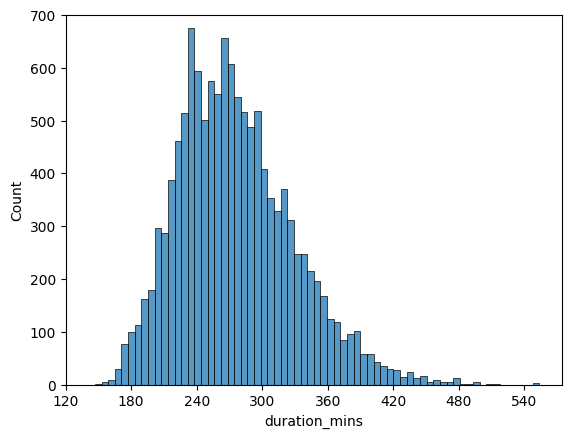

In [212]:
sns.histplot(finished_times, x='duration_mins')
plt.xticks(x_ticks);
plt.ylim(0,y_lim)

### 1b) Overall distribution with peak features added

(0.0, 700.0)

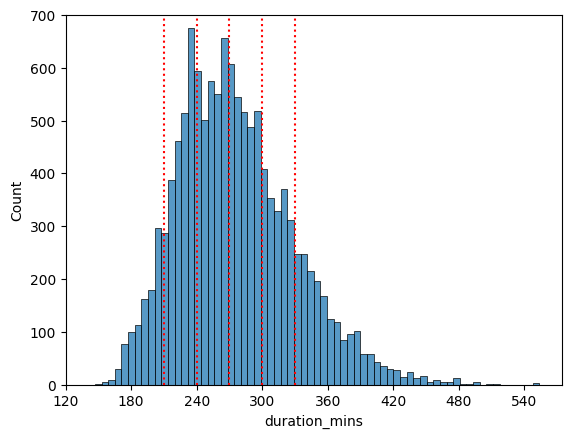

In [214]:
theoretical_peaks = [210, 240, 270, 300, 330]

sns.histplot(finished_times, x='duration_mins')
plt.vlines(x=theoretical_peaks, ymin=0, ymax=700, colors='red', linestyles=':')
plt.xticks(x_ticks);
plt.ylim(0,y_lim)

### 1c) Where do I lie?

In [215]:
me_mask = finished_times['bib_number'] == 36640

(0.0, 700.0)

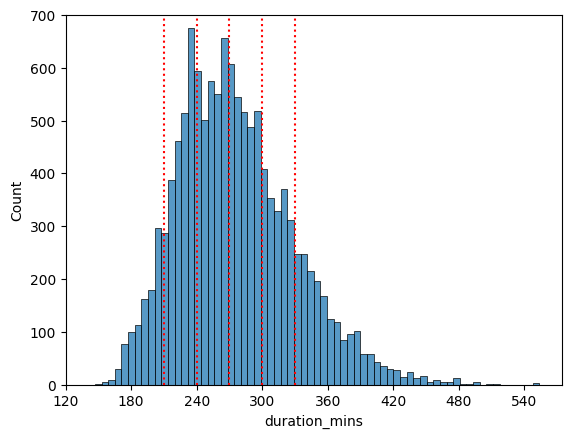

In [224]:
sns.histplot(finished_times, x='duration_mins')
plt.vlines(x=theoretical_peaks, ymin=0, ymax=700, colors='red', linestyles=':')
plt.xticks(x_ticks);
plt.ylim(0,y_lim)

## 2) Is it log normal?

In [237]:
finished_times['log_duration_mins'] = np.log(finished_times['duration_mins'])

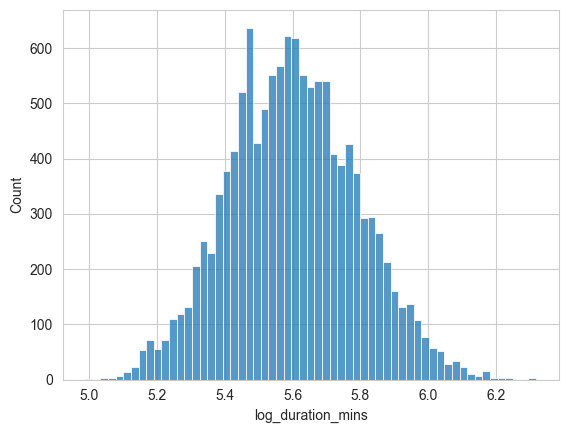

In [281]:
sns.histplot(finished_times, x='log_duration_mins');
sns.set_style("whitegrid")

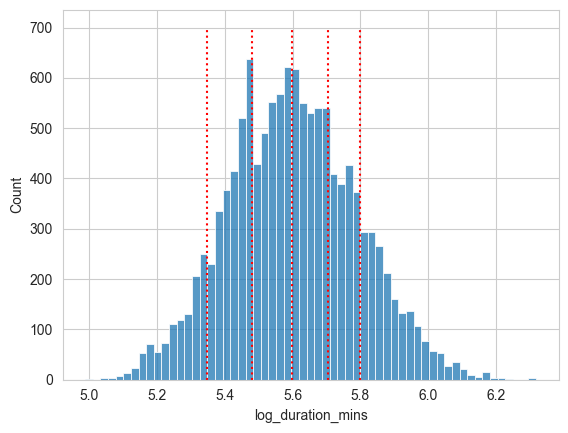

In [280]:
sns.histplot(finished_times, x='log_duration_mins')
plt.vlines(x=np.log(theoretical_peaks), ymin=0, ymax=700, colors='red', linestyles=':');
sns.set_style("whitegrid")

It looks to be log normal minus the peaks around specific times. Therefore we can estimate the mean and std to get a given distribution.

In [241]:
log_mu = finished_times['log_duration_mins'].mean()
log_sigma = finished_times['log_duration_mins'].std()

In [271]:
from scipy.stats import norm, lognorm

In [261]:
print(f"log mean: {log_mu}, \nlog std: {log_sigma}")

log mean: 5.6014030650971955, 
log std: 0.18910338441413085


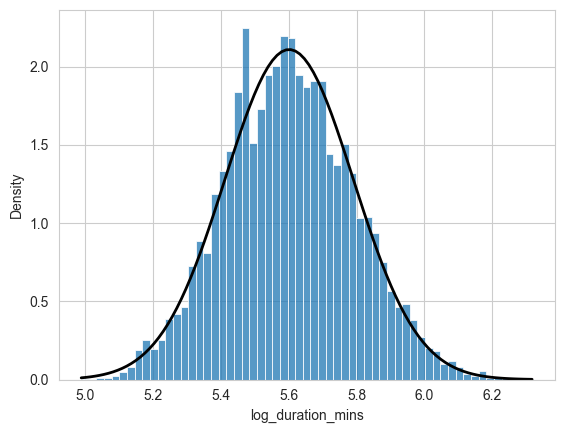

In [279]:
x = np.linspace(finished_times['log_duration_mins'].min(), finished_times['log_duration_mins'].max(), 100)
p = norm.pdf(x, log_mu, log_sigma)
plt.plot(x, p, 'k', linewidth=2, label='Normal PDF')
sns.histplot(finished_times, x='log_duration_mins', stat='density');
sns.set_style("whitegrid")

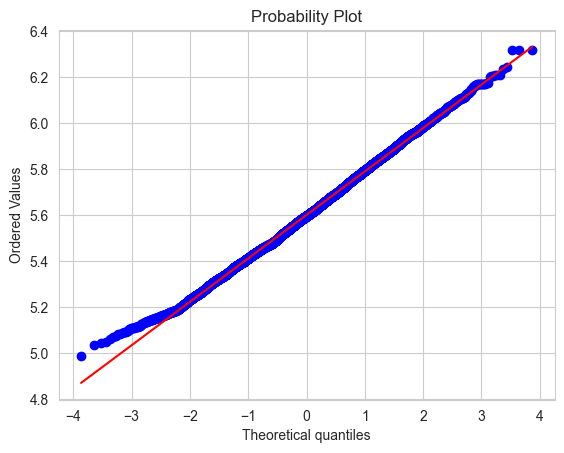

In [278]:
import seaborn as sns
from seaborn_qqplot import pplot
import scipy.stats as stats

stats.probplot(finished_times['log_duration_mins'], dist="norm", plot=plt); 
sns.set_style("whitegrid")

In [262]:
finished_times['log_log_duration_mins'] = np.log(finished_times['log_duration_mins'])

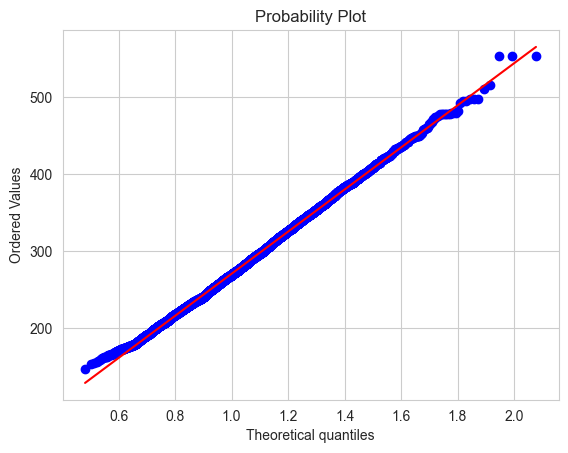

In [ ]:
shape, loc, scale = stats.lognorm.fit(finished_times['duration_mins'], floc=0)

stats.probplot(
    finished_times['duration_mins'],
    dist=stats.lognorm,
    sparams=(shape,),
    plot=plt
)
plt.show()
sns.set_style("whitegrid")

In [ ]:
shape, loc, scale = stats.lognorm.fit(finished_times['duration_mins'], floc=0)

follows a log normal distribution with mu=5.6014030650971955, sigma=0.18910338441413085


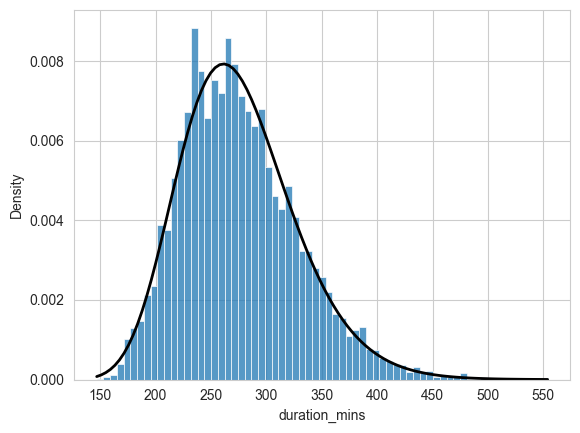

In [286]:
x = np.linspace(finished_times['duration_mins'].min(), finished_times['duration_mins'].max(), 100)

#p = lognorm.pdf(x, log_sigma,loc=0, scale=np.exp(log_mu))
p = lognorm.pdf(x, shape,loc=0, scale=scale)

plt.plot(x, p, 'k', linewidth=2, label='Log Normal PDF')
sns.histplot(finished_times, x='duration_mins', stat='density');

print(f'follows a log normal distribution with mu={log_mu}, sigma={log_sigma}')


In [287]:
#KS test
D, p_value = stats.kstest(
    finished_times['duration_mins'],
    'lognorm',
    args=(shape, loc, scale)
)

print(f"KS test statistic: {D}")
print(f"p-value: {p_value}")

KS test statistic: 0.02195637007167983
p-value: 1.0640942545258615e-05


In [295]:
data = finished_times['duration_mins']
shape, loc, scale = stats.lognorm.fit(data, floc=0)
bins = np.linspace(data.min(), data.max(), 10)
observed, _ = np.histogram(data, bins=bins)

# Calculate expected counts
cdf_vals = stats.lognorm.cdf(bins, shape, loc, scale)
expected = np.diff(cdf_vals) * len(data)

# Ensure sums match (fix for numerical precision)
expected = expected * observed.sum() / expected.sum()

# Perform chi-squared test
chi2_stat, p_value = stats.chisquare(observed, f_exp=expected)

print(f"Chi-squared statistic: {chi2_stat:.2f}")
print(f"P-value: {p_value:.4f}")

Chi-squared statistic: 29.70
P-value: 0.0002


## Look at age and sex differences:

In [371]:
counts = finished_times.groupby(['sex', 'age_min']).agg(count = ('bib_number', 'count'))
counts['percentage'] = counts['count']/ finished_times.shape[0]
counts.reset_index(inplace=True)

counts['label'] = counts['sex'] + ' - ' +counts['age_min'].astype('str')

In [372]:
counts.sort_values(by='percentage', ascending=False, inplace=True)

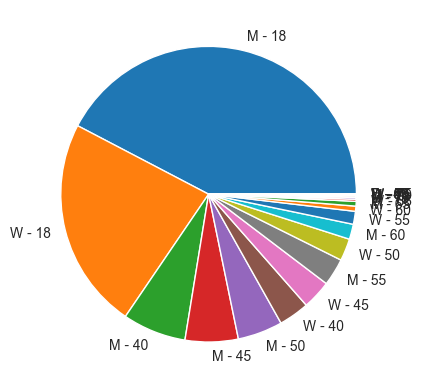

In [364]:
plt.pie(counts['percentage'], labels=counts['label']);

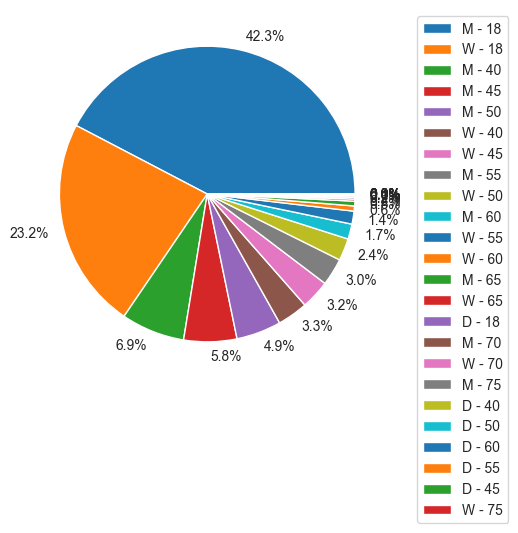

In [375]:
percentages = [f'{p*100:.1f}%' for p in counts['percentage']]

legend_labels = counts['label']

wedges, _ = plt.pie(counts['percentage'], labels=percentages)

plt.legend(wedges, legend_labels, loc='best', bbox_to_anchor=(1.05, 1))

plt.show()

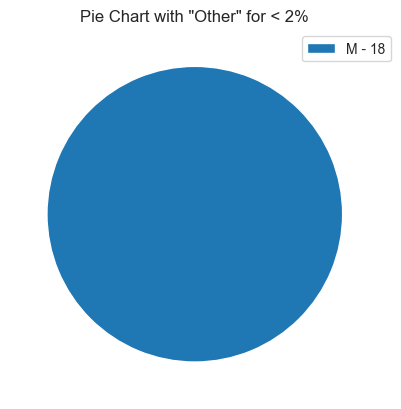

In [376]:
import pandas as pd
import matplotlib.pyplot as plt

# Set threshold
threshold = 2

# Separate main and other slices
main = counts[counts['percentage'] >= threshold]
other = counts[counts['percentage'] < threshold]

# Combine small slices into "Other"
if not other.empty:
    main = pd.concat([main, pd.DataFrame({
        'label': ['Other'],
        'percentage': [other['percentage'].sum()]
    })])

# Plot the pie chart
plt.pie(main['percentage'], labels=None)  # No labels inside wedges


# Add legend
plt.legend(legend_labels, loc='best', bbox_to_anchor=(1.05, 1))
plt.title('Pie Chart with "Other" for < 2%')
plt.show()

In [313]:
female_mask = finished_times['sex'] == 'W'

def age_mask(min_age: int):
    return finished_times['age_min'] == min_age

In [304]:
finished_times[~female_mask]

,bib_number,name,finish_time,hyper_link,sex,age_min,disqualified,did_not_finish,duration_mins,age_max,age_mid,duration_mins_log,log_duration_mins,log_log_duration_mins
0,15554,Matt Aaronson,0 days 03:51:13,?content=detail&fpid=search&pid=search&idp=9TG...,M,18,False,False,231.216667,39.0,28.5,5.443355,5.443355,1.694396
3,32897,Adam Abbott,0 days 05:18:58,?content=detail&fpid=search&pid=search&idp=9TG...,M,18,False,False,318.966667,39.0,28.5,5.765087,5.765087,1.751820
4,20095,Alexander Abbott,0 days 03:21:27,?content=detail&fpid=search&pid=search&idp=9TG...,M,18,False,False,201.450000,39.0,28.5,5.305541,5.305541,1.668752
5,17587,Ben Abbott,0 days 03:58:49,?content=detail&fpid=search&pid=search&idp=9TG...,M,18,False,False,238.816667,39.0,28.5,5.475696,5.475696,1.700319
7,25090,Will Abell,0 days 03:06:07,?content=detail&fpid=search&pid=search&idp=9TG...,M,18,False,False,186.116667,39.0,28.5,5.226374,5.226374,1.653718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,43032,Constantinos Christodoulou,0 days 07:30:12,?content=detail&fpid=search&pid=search&idp=9TG...,M,75,False,False,450.200000,75.0,75.0,6.109692,6.109692,1.809876
5,32805,Anthony Hansen,0 days 06:29:44,?content=detail&fpid=search&pid=search&idp=9TG...,M,75,False,False,389.733333,75.0,75.0,5.965463,5.965463,1.785987
6,18820,Richard Hillsdon,0 days 06:58:47,?content=detail&fpid=search&pid=search&idp=9TG...,M,75,False,False,418.783333,75.0,75.0,6.037354,6.037354,1.797966
8,30417,Kelvin Macdonald,0 days 06:59:44,?content=detail&fpid=search&pid=search&idp=9TG...,M,75,False,False,419.733333,75.0,75.0,6.039620,6.039620,1.798341


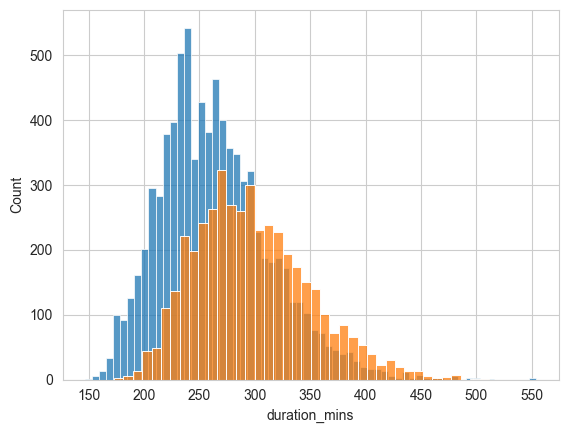

In [319]:
sns.histplot(finished_times[~female_mask], x='duration_mins')
sns.histplot(finished_times[female_mask], x='duration_mins')
plt.show()

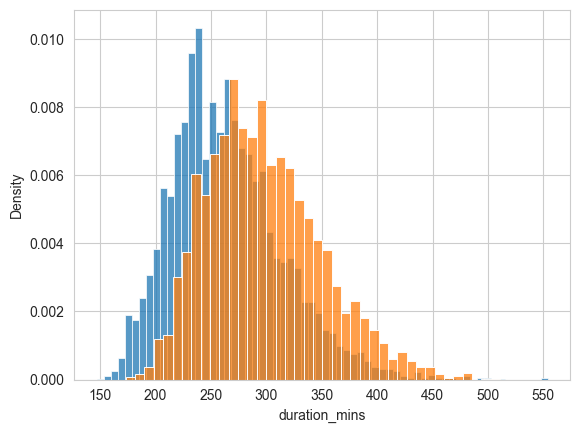

In [321]:
sns.histplot(finished_times[~female_mask], x='duration_mins', stat='density')
sns.histplot(finished_times[female_mask], x='duration_mins', stat='density')
plt.show()

In [315]:
finished_times['age_min'].unique()

array([18, 40, 45, 50, 55, 60, 65, 70, 75])

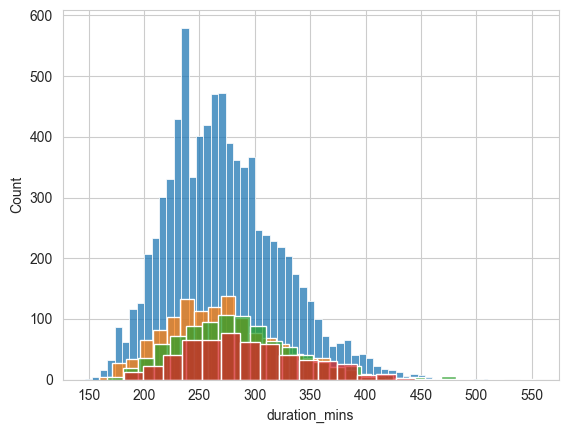

In [322]:
sns.histplot(finished_times[age_mask(18)], x='duration_mins')
sns.histplot(finished_times[age_mask(40)], x='duration_mins')
sns.histplot(finished_times[age_mask(50)], x='duration_mins')
sns.histplot(finished_times[age_mask(55)], x='duration_mins')
#sns.histplot(finished_times[age_mask(60)], x='duration_mins', stat='density')
#sns.histplot(finished_times[age_mask(65)], x='duration_mins', stat='density')
#sns.histplot(finished_times[age_mask(70)], x='duration_mins', stat='density')
#sns.histplot(finished_times[age_mask(75)], x='duration_mins', stat='density')
plt.show()